In [136]:
import os, json, re, getpass
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [137]:
# Take details from user

weight = 70
portion_consumed = 0.3

In [138]:
# Using GoogleVisionOCR for text extraction from bill

from __future__ import annotations
import io
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from google.cloud import vision

class GoogleVisionArgs(BaseModel):
    image_path: str = Field(..., description="Path to the image on disk")

@tool("google_vision_ocr", args_schema=GoogleVisionArgs)
def google_vision_ocr(image_path: str) -> str:
    """Extract text from an image using Google Cloud Vision and return the raw OCR text."""
    client = vision.ImageAnnotatorClient()
    with io.open(image_path, "rb") as f:
        content = f.read()

    image = vision.Image(content=content)
    response = client.text_detection(image=image)

    if response.error and response.error.message:
        raise RuntimeError(f"Google Vision API Error: {response.error.message}")

    annotations = response.text_annotations
    if not annotations:
        return "No text found"
    return annotations[0].description.strip()


In [139]:
bill_img = 'images/bill2.jpeg'
bill_text = google_vision_ocr(bill_img)
print(bill_text)

SAPTAGIRI
PURE VEG
VERSOLI LONAVALA, NEAR TOLL PLAZA,
OLD MUMBAI HIGHWAY ROAD, TAL. MAVAL,
DIST PUNE, POST- KAIVALYADHAM 410403
AC- BILL
Bl. No. 7
T.15
Captain
09-Feb-25
Rohit
12:32 PM
Particulars
Qty Rate
Amt
MINIRAL WATER 1 LTR 2
30
60
TEA
4
38
152
BUTTER MASALA
2
135
270
DOSA
MYSORE MASALA
2 140
280
DOSA
TOMATO ONION
1 120
120
UTTAPPAM(MIX)
MASALA DOSA
1
120
120
EXTRA CHESSE
1
30
30
MEDU VADA
1
100
100
FILTER COFFEE
2
50
100
1232.00
SGST @2.50%
30.80
CGST @2/50%
30.80
FOOD Total:
1294
TOTAL
1294.00
MOB: 9967831583/9702831583
GSTIN: 27AXCPS7382J2ZT
**** Thank You, Visit Again
AAAA


In [140]:
# Prompt to retireve calories for food items

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import json
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model="llama3.2")

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are precise food extarctor"),
    ("human", """Extract food items, their quantities, and prices
from the following restaurant bill text. Strictly return valid JSON as shown below.
Don't write price as mathematical equation. qty and price should int or float strictly.
Format:
[
  {{ "item": "Butter Chicken", "qty": 1, "price": 250 }},
  {{ "item": "Naan", "qty": 2, "price": 60 }}
]
Only return json format , no other text.
Bill Text:
{bill_text})
""")])

chain = prompt | llm | StrOutputParser()
food_data = chain.invoke({"bill_text": bill_text})
food_data = json.loads(food_data) 
print(food_data)



[{'item': 'Mineral Water', 'qty': 1, 'price': 60}, {'item': 'Tea', 'qty': 4, 'price': 38}, {'item': 'Butter Masala', 'qty': 2, 'price': 135}, {'item': 'Dosa', 'qty': 3, 'price': 140}, {'item': 'Tomato Onion', 'qty': 1, 'price': 120}, {'item': 'Uttappam(Mix)', 'qty': 2, 'price': 120}, {'item': 'Masala Dosa', 'qty': 1, 'price': 120}, {'item': 'Extra Chesse', 'qty': 1, 'price': 30}, {'item': 'Medu Vada', 'qty': 1, 'price': 100}, {'item': 'Filter Coffee', 'qty': 2, 'price': 50}]


In [141]:
# Using Nutritionix API for retireving calories of a food

import os
import requests
import pandas as pd
from typing import List, Dict, Type
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool

class CalorieInput(BaseModel):
    food_data: List[Dict] = Field(..., description="List of items with name, qty, and price")


class CalorieLookupTool(BaseTool):
    name: str = "Calorie Calculator"
    description: str = "Looks up calories for a list of food items using Nutritionix"
    args_schema: Type[BaseModel] = CalorieInput

    def _run(self, food_data: List[Dict], **kwargs) -> str:
        url = "https://trackapi.nutritionix.com/v2/natural/nutrients"
        headers = {
            "Content-Type": "application/json",
            "x-app-id": os.getenv("APPID"),
            "x-app-key": os.getenv("APPKEY"),
            "x-remote-user-id": "0"
        }

        calorie_data = []
        for food in food_data:
            query = food['item'].strip().lower()
            qty = food['qty']

            try:
                res = requests.post(url, headers=headers, json={"query": query})
                res.raise_for_status()
                result = res.json()
                calories = result['foods'][0].get('nf_calories', 0) if result['foods'] else 0
            except Exception as e:
                calories = 0

            calorie_data.append({
                "item": food['item'],
                "qty": qty,
                "price": food['price'],
                "calories_per_item": calories,
                "total_calories": calories * qty
            })

        df = pd.DataFrame(calorie_data)
        return df


In [142]:
# Stroing the calories data in a DataFrame

CalorieTool = CalorieLookupTool()
result_df = CalorieTool.invoke({"food_data": food_data})

# Divide the calories in half if item contains 'half' in name , eg: half fried rice

mask = result_df["item"].str.contains("half", case=False, na=False)
result_df.loc[mask, "calories_per_item"] /= 2
result_df.loc[mask, "total_calories"]    /= 2

print(result_df)

            item  qty  price  calories_per_item  total_calories
0  Mineral Water    1     60               0.00            0.00
1            Tea    4     38               1.78            7.12
2  Butter Masala    2    135             101.81          203.62
3           Dosa    3    140             167.67          503.01
4   Tomato Onion    1    120              22.14           22.14
5  Uttappam(Mix)    2    120               0.00            0.00
6    Masala Dosa    1    120             167.67          167.67
7   Extra Chesse    1     30             113.12          113.12
8      Medu Vada    1    100             134.88          134.88
9  Filter Coffee    2     50               2.37            4.74


In [143]:
# Calculate total calories consumed by user

total_calories_consumed = round(result_df['total_calories'].sum() * portion_consumed,2)
total_calories_consumed

np.float64(346.89)

In [144]:
# Embedding the json doc

import json
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

calories_json = '/Users/ashutoshpatil/Desktop/tone/met_activities_vectordb.json'
with open(calories_json, 'r') as f:
    calories_data = json.load(f)
calories_data

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  
output_path = '/Users/ashutoshpatil/Desktop/tone/met_activities_with_embeddings.json'

if os.path.exists(output_path):
    with open(output_path,'r') as f:
        calories_data = json.load(f)
        print(f"Loaded cached embeddings from {output_path}")
else:
    for item in tqdm(calories_data):
        text = item['text']
        embedding = model.encode(text).tolist()
        item['embedding'] = embedding 
 
    with open(output_path, 'w') as f:
        json.dump(calories_data, f, indent=2)

    print(f"Saved embedded data to {output_path}")


Loaded cached embeddings from /Users/ashutoshpatil/Desktop/tone/met_activities_with_embeddings.json


In [145]:
# Storing the embeddded doc in ChromaDB

import json
import chromadb
from chromadb.utils import embedding_functions

# Load your embedded JSON data
json_path = "/Users/ashutoshpatil/Desktop/tone/met_activities_with_embeddings.json"
with open(json_path, "r") as f:
    records = json.load(f)

client = chromadb.Client()
collection = client.get_or_create_collection(name="met_workouts")

# Proceed with data insertion only if collection is empty
if collection.count() == 0:
    ids = []
    documents = []
    metadatas = []
    embeddings = []

    for rec in records:
        ids.append(rec["id"])
        documents.append(rec["text"])
        metadatas.append(rec["metadata"])
        embeddings.append(rec["embedding"])

    collection.add(
        ids=ids,
        documents=documents,
        metadatas=metadatas,
        embeddings=embeddings
    )
    

    print(f"✅ Inserted {len(ids)} records into ChromaDB")
else:
    print("⚠️ Collection already contains data — skipping insert.")


⚠️ Collection already contains data — skipping insert.


In [146]:
# Tool to calculate time required to burn calories

class TimeToBurnInput(BaseModel):
    calories: float = Field(..., description="Calories to burn")
    weight: float = Field(..., description="User's body weight in kilograms")
    activities: Dict[str, float] = Field(..., description="Dictionary of {activity: MET}")

class TimeToBurnTool(BaseTool):
    name: str = "Time to Burn Calculator"
    description: str = "Calculates time to burn calories for multiple activities using MET values and body weight."
    args_schema: Type[BaseModel] = TimeToBurnInput

    def _run(self, calories: float, weight: float, activities: Dict[str, float], **kwargs) -> Dict[str, str]:
        try:
            results: Dict[str, str] = {}
            for activity, met in activities.items():
                time_min = round(calories / (met * weight * 0.0175), 1)
                results[activity] = f"{activity} — MET: {met}, Time: {time_min} min"
            return results  
        except Exception as e:
            return {"error": str(e)}

In [147]:
from typing import TypedDict, List, Optional
from typing_extensions import NotRequired
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END


# Graph State
class GraphState(TypedDict):
    question: str
    total_calories_consumed: float
    rewritten_question: NotRequired[Optional[str]]
    docs: NotRequired[List[Document]]
    answer: NotRequired[Optional[str]]
    route: NotRequired[str]
    steps: NotRequired[int]
    time_estimates: NotRequired[str]

## Nodes

In [148]:
# Web search node

from tavily import TavilyClient

tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

def web_answer(state: GraphState) -> GraphState:
    res = tavily_client.search(state["question"], max_results=3)
    results = res.get("results", [])

    # Collect snippets / content from results
    snippets = [r.get("content", "") for r in results if "content" in r]

    # Join and trim into 3–4 lines
    combined_text = " ".join(snippets)
    short_summary = " ".join(combined_text.split()[:60])  # ~3–4 lines worth of words

    return {**state, "answer": short_summary}

In [149]:
# Query analysis node

route_prompt = ChatPromptTemplate.from_messages([
    ("system",
     """You are an expert router that decides if a user question should go to RAG or Web.

RAG contains documents ONLY about physical activities and their MET scores.
- If the question is about exercises, sports, calorie burn, gym, physical activity intensity, or MET values → answer: "rag".
- If the question is about people, politics, countries, current events, general knowledge, or anything else → answer: "web".

Always output exactly one word: either "rag" or "web".
"""),
    ("human", "{question}")
])

def query_analysis(state: GraphState) -> GraphState:
    route = llm.invoke(route_prompt.format_messages(question=state["question"])).content.strip().lower()
    if route not in ("rag", "web"):
        route = "rag"
    return {**state, "route": route}

In [150]:
# Retreiver node

def retrieve(state: GraphState) -> GraphState:
    q = state.get("rewritten_question") or state["question"]
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    # Embed the query
    query_emb = embedding_model.encode(q).tolist()

    # Query Chroma for top-k results
    results = collection.query(
        query_embeddings=[query_emb],
        n_results=5
    )

    # Convert to LangChain Document objects
    docs = [
        Document(page_content=text, metadata=meta)
        for text, meta in zip(results["documents"][0], results["metadatas"][0])
    ]

    return {**state, "docs": docs}

In [151]:
# Grader node

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a grader for document retrieval relevance. 
Decide if the retrieved documents are good enough to answer the question.

Rules:
- Say 'yes' if MOST of the top documents (e.g., 2–3 out of 5) are clearly related to the question.  
- Say 'no' if the majority are irrelevant, off-topic, or there are no meaningful matches.  
- Do not be overly strict: partial matches (e.g., same category like "Sports" when user asked "Football") should count as relevant."""),
    ("human", "Question: {question}\n\nRetrieved Docs:\n{docs}")
])

def grade_docs(state: GraphState) -> GraphState:
    chunks = "\n".join([d.page_content for d in state["docs"]])
    decision = llm.invoke(
        grade_prompt.format_messages(question=state["question"], docs=chunks or "[NO DOCS]")
    ).content.strip().lower()
    return {**state, "route": "rag_ok" if decision.startswith("y") else "rag_bad"}

In [152]:
# Rewrite node

rewrite_prompt = ChatPromptTemplate.from_messages([
    ("system", "Rewrite the question as a short, simple search query. Do not add lists, categories, or explanations."),
    ("human", "Question: {question}\nDocs:\n{docs}")
])
def rewrite_question(state: GraphState) -> GraphState:
    chunks = "\n".join([d.page_content for d in state["docs"]]) or "[no docs]"
    new_q = llm.invoke(
        rewrite_prompt.format_messages(question=state["question"], docs=chunks)
    ).content.strip()
    return {
        **state,
        "rewritten_question": new_q,
        # increment retry counter each time this node runs
        "retry_count": state.get("retry_count", 0) + 1
    }

In [153]:
# Generate node

gen_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a fitness assistant helping the user burn {total_calories_consumed} calories.
Their preferred activity is: "{question}".

You have access to a list of potential exercises and their estimated times to burn calories. Out of the list pick 3 which you think are most relevant.

### Time Estimates:
{time_estimates}

### Output format:
Start with a short sentence restating the user's calorie goal.
Then for each exercise, provide the following in a consistent, structured block:

**Exercise: Activity name**  
- ⏱️ Estimated time: (pull the correct value from the time estimates above) 
- ✅ Why: A short, supportive explanation (focus on benefits, motivation, or modifications)

End with a motivational sentence encouraging the user to follow through.
"""),

("human", "Question: {question}\nDocs:\n{docs}")
])

def generate(state: GraphState) -> GraphState:
    docs_txt = "\n".join(d.page_content for d in state["docs"])
    ans = llm.invoke(
        gen_prompt.format_messages(question=state["question"],
            total_calories_consumed=state["total_calories_consumed"],
            time_estimates=state["time_estimates"],docs=docs_txt)
    ).content.strip()
    return {**state, "answer": ans}

In [154]:
# Hallucination grader node

halluc_prompt = ChatPromptTemplate.from_messages([
    ("system", "Say 'yes' if the answer is fully supported by docs, else 'no'."),
    ("human", "Docs:\n{docs}\nAnswer:\n{answer}")
])
def check_hallucination(state: GraphState) -> GraphState:
    docs_txt = "\n".join(d.page_content for d in state["docs"]) or "[no docs]"
    decision = llm.invoke(
        halluc_prompt.format_messages(docs=docs_txt, answer=state["answer"] or "")
    ).content.strip().lower()
    return {**state, "route": "answer_ok" if decision.startswith("y") else "answer_bad"}


In [155]:
# Answer relevancy checking node

answered_prompt = ChatPromptTemplate.from_messages([
    ("system", "Say 'yes' if the answer explicitly addresses the user's question."),
    ("human", "Question: {question}\nAnswer:\n{answer}")
])
def check_answered(state: GraphState) -> GraphState:
    decision = llm.invoke(
        answered_prompt.format_messages(
            question=state["question"], answer=state["answer"] or ""
        )
    ).content.strip().lower()
    return {**state, "route": "final" if decision.startswith("y") else "needs_more"}

In [156]:
# Node to calculate estimated time to burn calories

def time_to_burn(state: GraphState) -> GraphState:
    calories = state["total_calories_consumed"]
    weight = 70  
    tool = TimeToBurnTool()

    # Collect unique activities
    activities = {}
    for d in state.get("docs", []):
        met_value = d.metadata.get("MET") or d.metadata.get("met")
        if met_value:
            activity_name = (
                d.metadata.get("desc")
                or d.page_content
                or d.metadata.get("id")
                or "Unknown"
            )
            activities[activity_name] = met_value  

    if not activities:
        return {**state, "time_estimates": "No MET data found in docs."}

    results = tool._run(calories=calories, weight=weight, activities=activities)

    return {**state, "time_estimates": results}

In [157]:
# Abort node

def abort_node(state: GraphState) -> GraphState:
    return {**state, "answer": "Sorry, I couldn’t find a good answer after several attempts."}

## Graph Flow

In [158]:
# Build Graph

g = StateGraph(GraphState)

g.set_entry_point("query_analysis")

g.add_node("query_analysis", query_analysis)
g.add_node("retrieve", retrieve)
g.add_node("grade_docs", grade_docs)
g.add_node("rewrite_question", rewrite_question)
g.add_node("generate", generate)
g.add_node("time_to_burn", time_to_burn)
g.add_node("check_hallucination", check_hallucination)
g.add_node("check_answered", check_answered)
g.add_node("web_answer", web_answer)
g.add_node("abort", abort_node)

# Flow of graph

g.add_conditional_edges(
    "query_analysis",
    lambda s: s["route"],
    {"rag": "retrieve", "web": "web_answer"}
)
g.add_edge("web_answer", END)
g.add_edge("retrieve", "grade_docs")

g.add_conditional_edges(
    "grade_docs",
    lambda s: s["route"],
    {"rag_ok": "time_to_burn", "rag_bad": "rewrite_question"}
)

g.add_edge("time_to_burn", "generate")
g.add_edge("generate", "check_hallucination")

g.add_conditional_edges(
    "check_hallucination",
    lambda s: s["route"],
    {"answer_ok": "check_answered", "answer_bad": "rewrite_question"}
)

g.add_conditional_edges(
    "check_answered",
    lambda s: s["route"],
    {"final": END, "needs_more": "rewrite_question"}
)


MAX_RETRIES = 3

g.add_conditional_edges(
    "rewrite_question",
    lambda s: "retrieve" if s.get("retry_count", 0) < MAX_RETRIES else "abort",
    {"retrieve": "retrieve", "abort": "abort"}
)

graph = g.compile(debug = True)

In [159]:
import nest_asyncio
nest_asyncio.apply()

from langchain_core.runnables.graph import MermaidDrawMethod

png_bytes = graph.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.PYPPETEER
)
with open("graph.png", "wb") as f:
    f.write(png_bytes)
print("Saved graph.png")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved graph.png


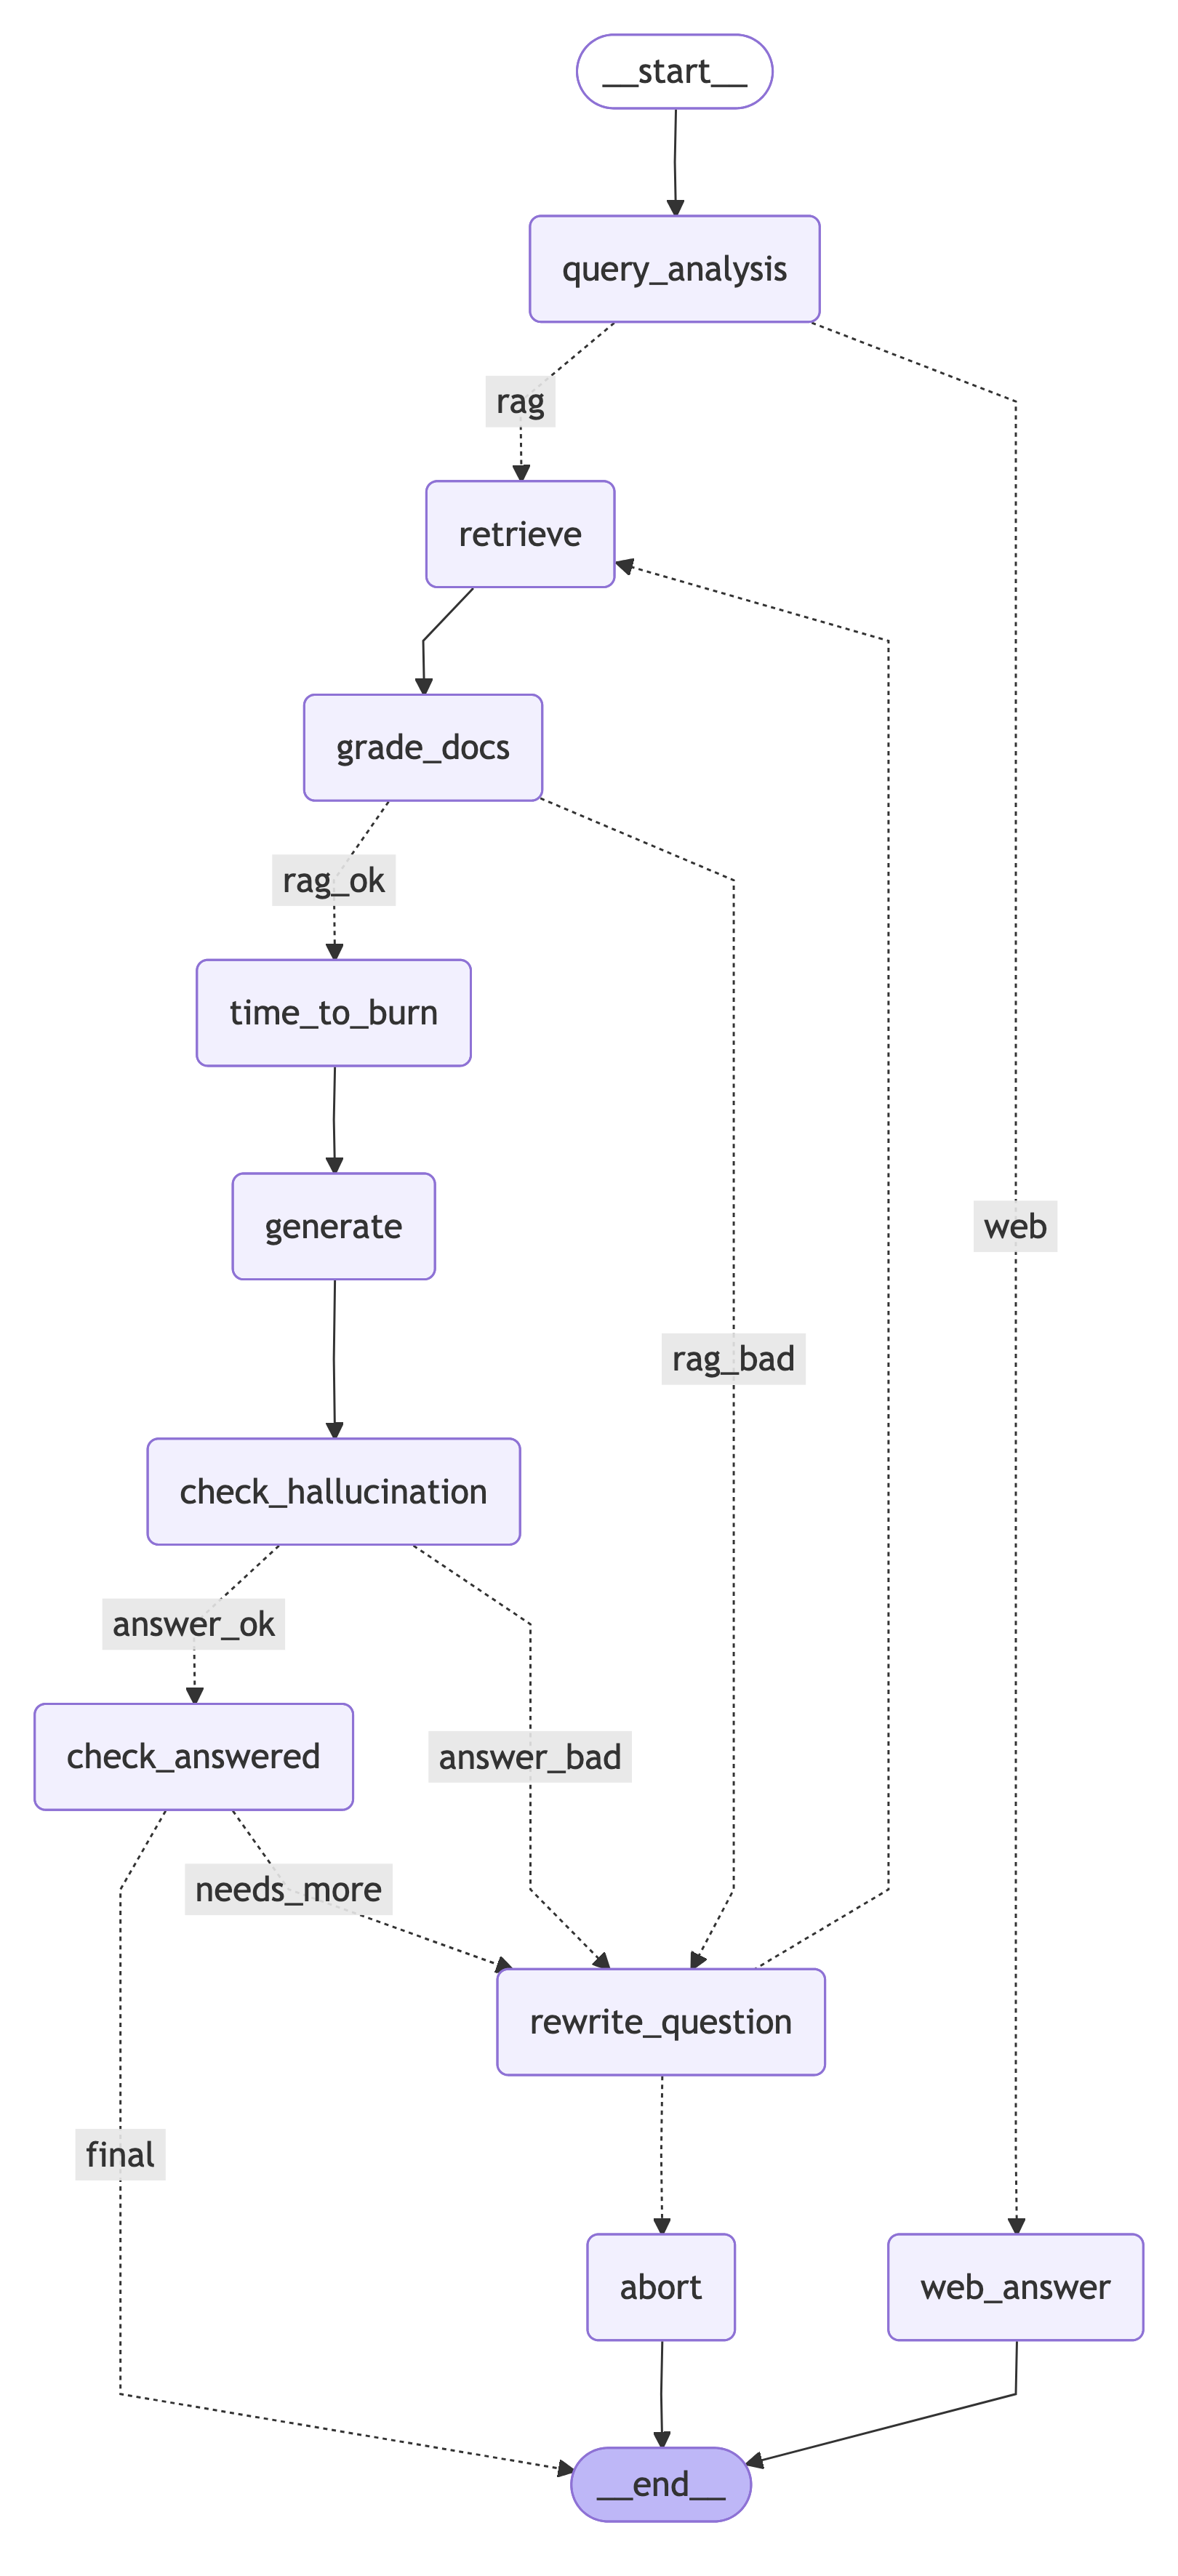

In [160]:
from IPython.display import Image
Image(png_bytes, width=600)

In [161]:
result = graph.invoke({"question": "exercises that do not require gym","total_calories_consumed": total_calories_consumed})

[values] {'question': 'exercises that do not require gym', 'total_calories_consumed': np.float64(346.89)}
[updates] {'query_analysis': {'question': 'exercises that do not require gym', 'total_calories_consumed': np.float64(346.89), 'route': 'rag'}}
[values] {'question': 'exercises that do not require gym', 'total_calories_consumed': np.float64(346.89), 'route': 'rag'}
[updates] {'retrieve': {'question': 'exercises that do not require gym', 'total_calories_consumed': np.float64(346.89), 'route': 'rag', 'docs': [Document(metadata={'MET': 3.0, 'category': 'Exercise'}, page_content='Body weight resistance exercises (e.g., squat, lunge, push-up, crunch), general'), Document(metadata={'MET': 6.5, 'category': 'Exercise'}, page_content='Body weight resistance exercises (e.g., squat, lunge, push-up, crunch), high intensity'), Document(metadata={'MET': 7.5, 'category': 'Exercise'}, page_content='Calisthenics (e.g., pushups, sit ups, pull-ups, jumping jacks, burpees, battling ropes), vigorous eff

## Final Result

In [162]:
print(result['answer'])

You want to burn 346.89 calories without visiting a gym.

Here are three exercises that can help you achieve your goal:

**Exercise: Body weight resistance exercises (e.g., squat, lunge, push-up, crunch), general**
- ⏱️ Estimated time: 94.4 min
- ✅ Why: This exercise is great for beginners as it works multiple muscle groups and can be modified to suit different fitness levels.

**Exercise: Calisthenics (e.g., pushups, sit ups, pull-ups, jumping jacks, burpees), vigorous effort**
- ⏱️ Estimated time: 37.8 min
- ✅ Why: This exercise is an excellent way to improve cardiovascular health and burn calories in a short amount of time.

**Exercise: Video, exercise workouts, TV conditioning programs (e.g., cardio-resistance training), vigorous**
- ⏱️ Estimated time: 47.2 min
- ✅ Why: Following along with a video workout can be motivating and help you stay on track, even when you're at home.

Remember to stay committed and push through any challenges - you got this!
